<a href="https://colab.research.google.com/github/virslaan/Algorithms--SAGA/blob/main/facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [140]:
import random

**Performing Required imports** 

In [141]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

**Connecting Google Drive to access the data**

In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
df = pd.read_csv('/content/drive/MyDrive/facial_adl/fer2013.csv')
print("Data Set shape is ",df.shape)


Data Set shape is  (35887, 3)


**Analysis of Data is done in this section**

In [144]:

df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [145]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

Let's See how many emotions do we have:

In [146]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


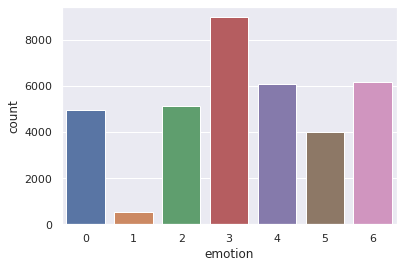

In [147]:
sns.countplot(df.emotion)
pyplot.show()

`On observation we are seeing that the majority classes belongs to


>  3:Happy
>  4:Sad
 6:Neutral we are also intersted in these three classes only.`

> Indented block





In [148]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

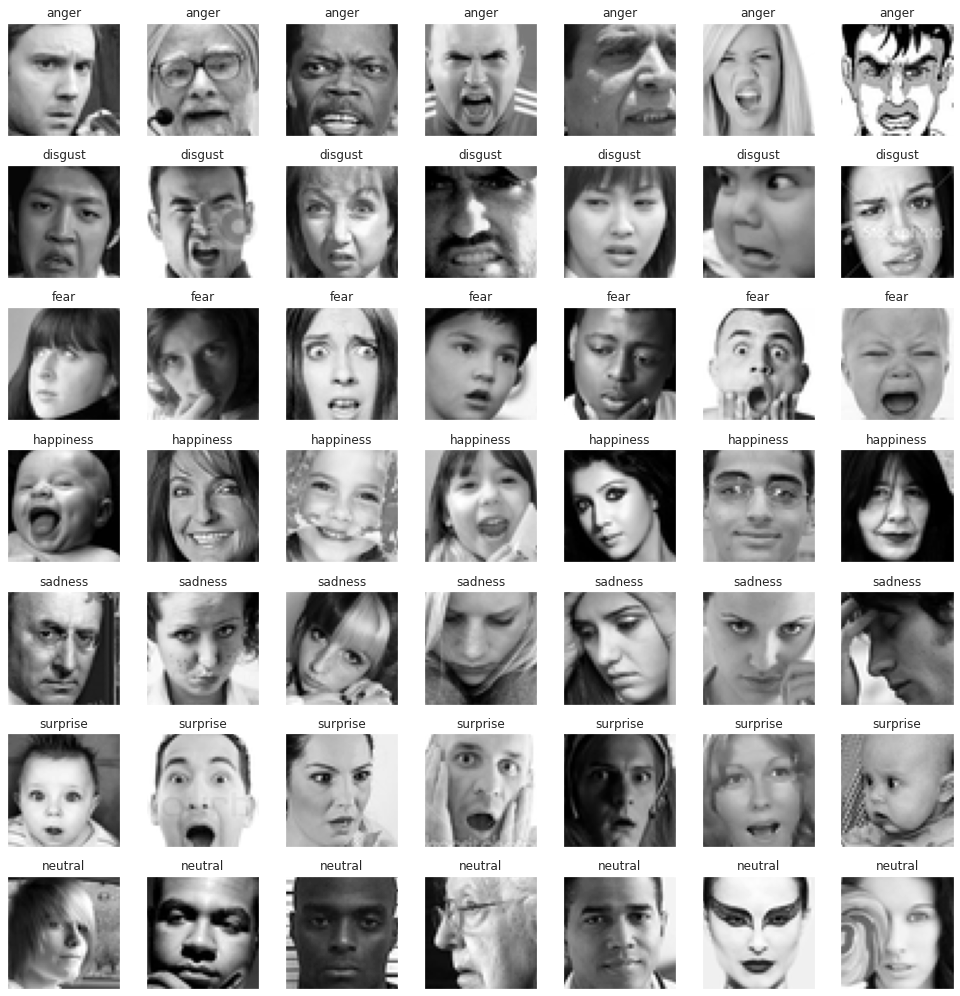

In [149]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [150]:
INTERESTED_LABELS = [3,4]

In [151]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(15066, 3)

In [152]:
df.columns

Index(['emotion', 'pixels', 'Usage'], dtype='object')

`Now I will make the data compatible for neural networks.`

In [153]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [154]:
img_array.shape

(15066, 48, 48, 1)

In [155]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(15066, 2)

In [156]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1}


`Splitting the data into training and validation set.`

In [157]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((13559, 48, 48, 1), (1507, 48, 48, 1), (13559, 2), (1507, 2))

In [158]:
del df
del img_array
del img_labels

In [159]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [160]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [161]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [162]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [163]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [164]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

<ipython-input-164-22665cd605d0>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


423/423 [==============================] - 15s 32ms/step - loss: 0.8225 - accuracy: 0.5756 - val_loss: 0.6157 - val_accuracy: 0.6370 - lr: 0.0010
Epoch 2/100
423/423 [==============================] - 11s 27ms/step - loss: 0.6332 - accuracy: 0.6457 - val_loss: 0.5538 - val_accuracy: 0.7206 - lr: 0.0010
Epoch 3/100
423/423 [==============================] - 11s 26ms/step - loss: 0.5739 - accuracy: 0.6943 - val_loss: 0.4851 - val_accuracy: 0.7651 - lr: 0.0010
Epoch 4/100
423/423 [==============================] - 11s 25ms/step - loss: 0.4992 - accuracy: 0.7501 - val_loss: 0.5812 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 5/100
423/423 [==============================] - 11s 26ms/step - loss: 0.4315 - accuracy: 0.7950 - val_loss: 0.6078 - val_accuracy: 0.7319 - lr: 0.0010
Epoch 6/100
423/423 [==============================] - 11s 26ms/step - loss: 0.3781 - accuracy: 0.8264 - val_loss: 0.3186 - val_accuracy: 0.8746 - lr: 0.0010
Epoch 7/100
423/423 [==============================] - 11s 26ms/

In [194]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")

In [195]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras ‘/content/model.h5’ ‘/content/model’

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-12-03 20:47:05.732043: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-12-03 20:47:05.732229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-12-03 20:47:05.732252: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing librarie

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

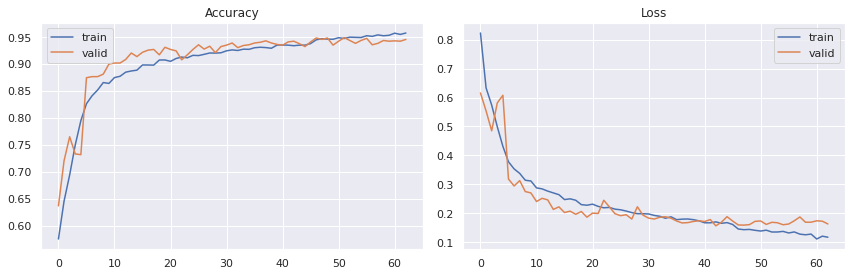

In [171]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

    The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

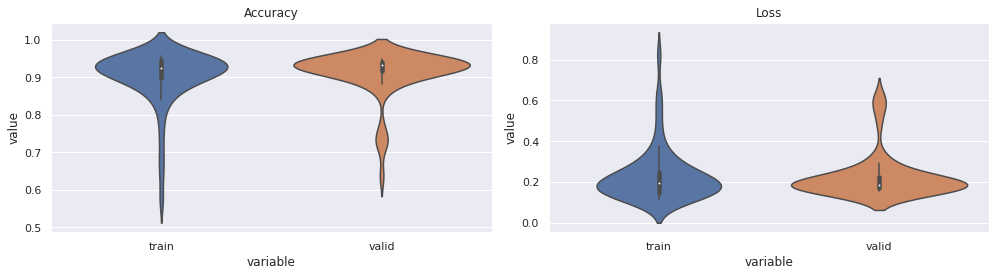

In [172]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

48/48 [==============================] - 1s 8ms/step
total wrong validation predictions: 77


              precision    recall  f1-score   support

           0       0.97      0.95      0.96       899
           1       0.92      0.95      0.94       608

    accuracy                           0.95      1507
   macro avg       0.95      0.95      0.95      1507
weighted avg       0.95      0.95      0.95      1507



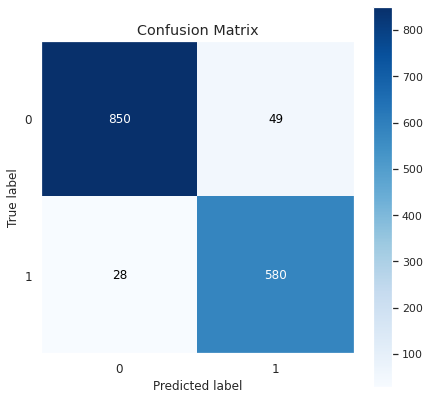

In [173]:
yhat_valid=np.argmax(model.predict(X_valid),axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [175]:
mapper = {
    0: "Happy",
    1: "Sad"
}

(48, 48)
1/1 [==============================] - 0s 29ms/step
(48, 48)
1/1 [==============================] - 0s 28ms/step
(48, 48)
1/1 [==============================] - 0s 30ms/step
(48, 48)
1/1 [==============================] - 0s 17ms/step
(48, 48)
1/1 [==============================] - 0s 16ms/step


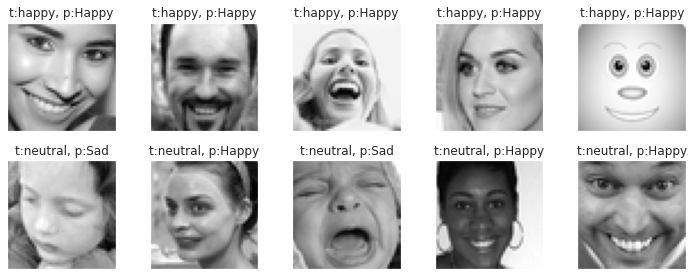

In [177]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==0)[0], size=5)
random_happy_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=5)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])#np.argmax(model.predict(X_valid),axis=1)
        print(sample_img.shape)
        ax.set_title(f"t:happy, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neutral, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")

        pyplot.tight_layout()

In [178]:
from PIL import Image
import matplotlib.pyplot as plt
def show_image(path):
  img=Image.open(path)
  original = img.convert("1")
  original.show()
  plt.imshow(original)
  plt.show()


In [179]:
import numpy as np
from PIL import Image
import cv2
import os


In [188]:
mood =0
def predict_mood(path):
    img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    img_pil = Image.fromarray(img_array)
    img_28x28 = np.array(img_pil.resize((48, 48), Image.ANTIALIAS))

    img_array = (img_28x28.flatten())
    img_array  = img_array.reshape(1,48,48,1)
    mood_detected=np.argmax(model.predict(img_array)[0])
    print()
    if(mood_detected == 0):
      print("Happy ! Hold Up...")
      show_image(path)
      open_nuetral()
    elif(mood_detected == 1):
      print("Sad")
      show_image(path)
      open_sad()
    elif(mood_detected == 2):
      print("Nuetral")
      show_image(path)
      open_nuetral()
   

In [189]:
from IPython.display import Javascript
def open_happy():
    url = 'https://open.spotify.com/playlist/37i9dQZF1DXdPec7aLTmlC'
    display(Javascript('window.open("{url}");'.format(url=url)))
    print("Play the song :",int((random.randint(0,80))*84/100))
   
def open_sad():
    url = 'https://open.spotify.com/playlist/37i9dQZF1DX7qK8ma5wgG1'
    display(Javascript('window.open("{url}");'.format(url=url)))
    print("Play the song :",int((random.randint(0,80))*84/100))

def open_nuetral():
    url = 'https://open.spotify.com/playlist/37i9dQZF1DXcBWIGoYBM5M'
    display(Javascript('window.open("{url}");'.format(url=url)))
    print("Play the song :",int((random.randint(0,80))*84/100))


1/1 [==============================] - 0s 17ms/step

Happy ! Hold Up...


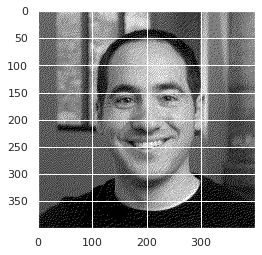

<IPython.core.display.Javascript object>

Play the song : 43


In [190]:
predict_mood("happy.png")

1/1 [==============================] - 0s 17ms/step

Happy ! Hold Up...


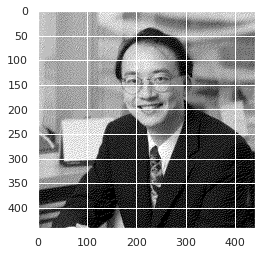

<IPython.core.display.Javascript object>

Play the song : 34


In [191]:
predict_mood("tat.png")

1/1 [==============================] - 0s 16ms/step

Happy ! Hold Up...


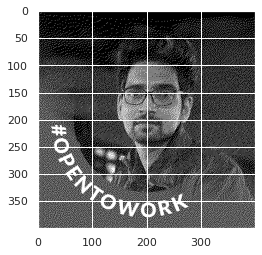

<IPython.core.display.Javascript object>

Play the song : 36


In [192]:
predict_mood("arvind2.png")

1/1 [==============================] - 0s 18ms/step

Sad


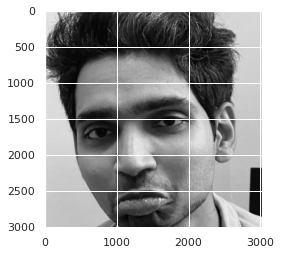

<IPython.core.display.Javascript object>

Play the song : 12


In [193]:
predict_mood("arvind.png")